In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

import joblib

# Load and Clean Data

Used dataset:
https://www.kaggle.com/datasets/anlgrbz/student-demographics-online-education-dataoulad/

In [25]:
# Assuming your data is in a CSV file named 'data.csv'
df = pd.read_csv('dataset/studentVle.csv')

# Grouping by 'code_module' and 'id_student', and summing 'sum_click'
student_vle = df.groupby(['id_student', 'code_module'])['sum_click'].sum().reset_index()

student_vle.head()

,id_student,code_module,sum_click
0,6516,AAA,2791
1,8462,DDD,656
2,11391,AAA,934
3,23629,BBB,161
4,23698,CCC,910


In [26]:
student_info = pd.read_csv('dataset/studentInfo.csv', usecols=['id_student', 'code_module', 'gender', 'highest_education', 'imd_band', 'age_band', 'studied_credits', 'disability', 'final_result'])

# Merge the two DataFrames on 'code_module' and 'id_student'
data = pd.merge(student_vle, student_info, on=['code_module', 'id_student'])

# Now you have all the information about students' clicks and their performance on a module
data.head()

,id_student,code_module,sum_click,gender,highest_education,imd_band,age_band,studied_credits,disability,final_result
0,6516,AAA,2791,M,HE Qualification,80-90%,35<=,60,N,Pass
1,8462,DDD,656,M,HE Qualification,30-40%,35<=,90,N,Withdrawn
2,8462,DDD,656,M,HE Qualification,30-40%,35<=,60,N,Withdrawn
3,11391,AAA,934,M,HE Qualification,90-100%,35<=,240,N,Pass
4,23629,BBB,161,F,Lower Than A Level,20-30%,18-21,60,N,Fail


In [4]:
data.isna().sum()

id_student           0
code_module          0
sum_click            0
gender               0
highest_education    0
imd_band             0
age_band             0
studied_credits      0
disability           0
final_result         0
dtype: int64

In [5]:
data["code_module"].value_counts()

code_module
FFF    7156
BBB    6682
DDD    5822
CCC    4034
EEE    2702
GGG    2368
AAA     737
Name: count, dtype: int64

In [6]:
data["imd_band"].value_counts()

imd_band
20-30%     3242
30-40%     3220
10-20      3060
40-50%     2948
50-60%     2873
0-10%      2848
60-70%     2689
70-80%     2652
80-90%     2534
90-100%    2374
?          1061
Name: count, dtype: int64

Our data is clean and ready for further processing, expect for the feature "imd_band" which has a category "?", meaning 'unknown". We will be replacing that with the mode since this is categorical column.

In [27]:
data["imd_band"] = data["imd_band"].replace('?', pd.NA)  # Convert '?' to NaN
data["imd_band"] = data["imd_band"].fillna(data["imd_band"].mode()[0])
# Let's check if the unknown values are replaced
data["imd_band"].value_counts()

imd_band
20-30%     4303
30-40%     3220
10-20      3060
40-50%     2948
50-60%     2873
0-10%      2848
60-70%     2689
70-80%     2652
80-90%     2534
90-100%    2374
Name: count, dtype: int64

Everything is clean now. You can now proceed with our preprocessing.

Before proceeding into further processing, we need to exclude the "final_result" column from the dataframe, since it is basically the label that we are lookig for. Keeping it will make us perform supervised learning which is not our objective for this lab.

In [28]:
target = data["final_result"]
df = data.drop(columns=["id_student","final_result"])

In [29]:
X = df.copy()

# Preprocess Data

### 1. First, I'll try to encode the categorical features:

In [30]:
X['gender'] = X['gender'].apply(lambda x: 1 if x == 'M' else 0)
X['disability'] = X['disability'].apply(lambda x: 1 if x == 'Y' else 0)

In [31]:
# Ordinal columns
ordinal_cols = ['code_module', 'highest_education', 'imd_band', 'age_band']
label_encoders = {}

# Fit and save each LabelEncoder
for col in ordinal_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    joblib.dump(le, f'encoder/label_encoder_{col}.pkl')
    
X.head()

,code_module,sum_click,gender,highest_education,imd_band,age_band,studied_credits,disability
0,0,2791,1,1,8,2,60,0
1,3,656,1,1,3,2,90,0
2,3,656,1,1,3,2,60,0
3,0,934,1,1,9,2,240,0
4,1,161,0,2,2,0,60,0


In [33]:
X["code_module"].value_counts()

code_module
5    7156
1    6682
3    5822
2    4034
4    2702
6    2368
0     737
Name: count, dtype: int64

### 2. Let's Normalize our data using the StandardScaler:

In [32]:
# Columns to be scaled
scale_cols = ['sum_click', 'studied_credits']

# Initialize and fit the scaler
scaler = StandardScaler()
X[scale_cols] = scaler.fit_transform(X[scale_cols])

# Save the scaler
joblib.dump(scaler, 'scaler/scaler.pkl')

X.head()

,code_module,sum_click,gender,highest_education,imd_band,age_band,studied_credits,disability
0,0,0.786464,1,1,8,2,-0.460525,0
1,3,-0.422658,1,1,3,2,0.293859,0
2,3,-0.422658,1,1,3,2,-0.460525,0
3,0,-0.265217,1,1,9,2,4.065774,0
4,1,-0.702993,0,2,2,0,-0.460525,0


Now, we can perform clustering

# Clustering Analysis:

### K-means:

c:\Users\abdel\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\abdel\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\abdel\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\abdel\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\abdel\anaconda3\Lib\site-packages\sklearn\clust

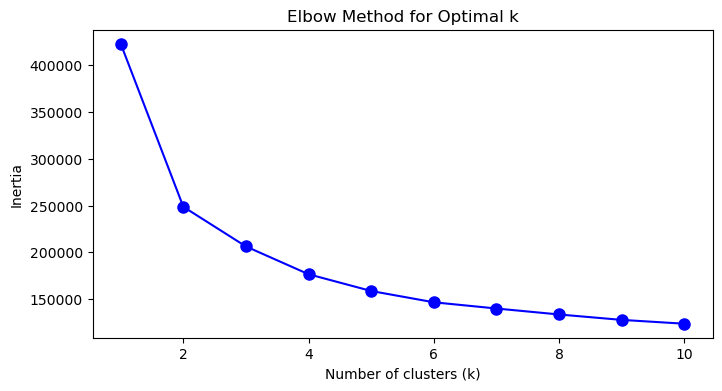

In [14]:
# Determine the optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [17]:
# Creating kmeans model with the optimal number of clusters
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster_kmeans'] = kmeans.fit_predict(X)

# Compute the silhouette score
silhouette_kmeans = silhouette_score(X, df["cluster_kmeans"])
calinski_harabasz_kmeans = calinski_harabasz_score(X, df["cluster_kmeans"])
davies_bouldin_kmeans = davies_bouldin_score(X, df["cluster_kmeans"])

print("K-means Silhouette Score:", silhouette_kmeans)
print("K-means Calinski-Harabasz Score:", calinski_harabasz_kmeans)
print("K-means Davies-Bouldin Score:", davies_bouldin_kmeans)

display(df.head())

c:\Users\abdel\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-means Silhouette Score: 0.34851543040407473
K-means Calinski-Harabasz Score: 20698.924538629097
K-means Davies-Bouldin Score: 1.1358744682297535


,code_module,sum_click,gender,highest_education,imd_band,age_band,studied_credits,disability,cluster_kmeans
0,AAA,2791,M,HE Qualification,80-90%,35<=,60,N,1
1,DDD,656,M,HE Qualification,30-40%,35<=,90,N,0
2,DDD,656,M,HE Qualification,30-40%,35<=,60,N,0
3,AAA,934,M,HE Qualification,90-100%,35<=,240,N,1
4,BBB,161,F,Lower Than A Level,20-30%,18-21,60,N,0


The optimal number of cluster is 2, since we have a high Silhouette Score, and a high Calinski-Harabasz Score with a Davies-Bouldin Score close to zero, which indicates that 2 is the optimal number of clusters. 

Having 3 or 4 cluster are also a close choice!

### Gaussian Mixture Model:

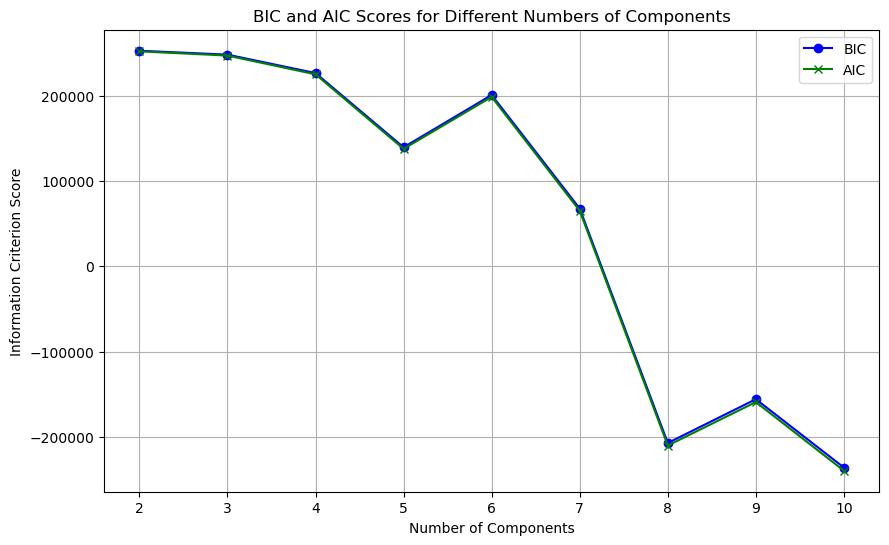

In [18]:
# Initialize a range of candidate numbers of components
n_components_range = range(2, 11)  # Choose a reasonable range of components

# Initialize lists to store BIC and AIC scores
bic_scores = []
aic_scores = []

# Fit GMM models for each candidate number of components
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))
    aic_scores.append(gmm.aic(X))

# Plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, marker='o', label='BIC', color='blue')
plt.plot(n_components_range, aic_scores, marker='x', label='AIC', color='green')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion Score')
plt.title('BIC and AIC Scores for Different Numbers of Components')
plt.legend()
plt.grid(True)
plt.show()

We got BIC and AIC scores close to 0 when having 7 clusters, indicating the optimal number of clusters 7 according to this model!

In [19]:
# Initialize Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)

# Predict the cluster labels
df["cluster_gmm"] = gmm.fit_predict(X)

# Evaluate the clustering
silhouette = silhouette_score(X, df["cluster_gmm"])
calinski_harabasz = calinski_harabasz_score(X, df["cluster_gmm"])
davies_bouldin = davies_bouldin_score(X, df["cluster_gmm"])

print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Score:", calinski_harabasz)
print("Davies-Bouldin Score:", davies_bouldin)


Silhouette Score: 0.03135338070005888
Calinski-Harabasz Score: 246.28250390831346
Davies-Bouldin Score: 6.169996838196835


### DBSCAN

In [20]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Predict the cluster labels
df["cluster_dbscan"] = dbscan.fit_predict(X)

# Evaluate DBSCAN
silhouette_dbscan = silhouette_score(X, df["cluster_dbscan"])
calinski_harabasz_dbscan = calinski_harabasz_score(X, df["cluster_dbscan"])
davies_bouldin_dbscan = davies_bouldin_score(X, df["cluster_dbscan"])

print("DBSCAN Silhouette Score:", silhouette_dbscan)
print("DBSCAN Calinski-Harabasz Score:", calinski_harabasz_dbscan)
print("DBSCAN Davies-Bouldin Score:", davies_bouldin_dbscan)

DBSCAN Silhouette Score: 0.14238241521685147
DBSCAN Calinski-Harabasz Score: 47.37672460697209
DBSCAN Davies-Bouldin Score: 1.3002806066066956


# Conclusion

### Showing the clustering done for each record by different models

In [21]:
display(df.head())

,code_module,sum_click,gender,highest_education,imd_band,age_band,studied_credits,disability,cluster_kmeans,cluster_gmm,cluster_dbscan
0,AAA,2791,M,HE Qualification,80-90%,35<=,60,N,1,1,-1
1,DDD,656,M,HE Qualification,30-40%,35<=,90,N,0,1,-1
2,DDD,656,M,HE Qualification,30-40%,35<=,60,N,0,1,-1
3,AAA,934,M,HE Qualification,90-100%,35<=,240,N,1,1,-1
4,BBB,161,F,Lower Than A Level,20-30%,18-21,60,N,0,1,0


### Algorithms Benchmarking:

| Algorithm         | Silhouette Score | Calinski-Harabasz Score | Davies-Bouldin Score |
|-------------------|------------------|-------------------------|----------------------|
| K-means           | 0.348515         | 20698.92                | 1.1358               |
| Gaussian Mixture  | 0.031353         | 246.28                  | 6.1285               |
| DBSCAN            | 0.142382         | 47.37                   | 6.1699               |

### Interpretation:

- **K-means**: Achieved the best performance with the highest Silhouette Score (0.348515) and Calinski-Harabasz Score (20698.92), along with the lowest Davies-Bouldin Score (1.1358). This indicates well-defined and compact clusters with low intra-cluster distance and high inter-cluster distance. 

- **DBSCAN**: Showed moderate performance with a Silhouette Score of 0.142382 and a relatively low Calinski-Harabasz Score (47.37). The high Davies-Bouldin Score (6.1699) suggests less distinct clusters and higher intra-cluster variance, suitable for datasets with irregular cluster shapes and noise points. 

- **Gaussian Mixture**: Performed the poorest, with the lowest Silhouette Score (0.031353) and Calinski-Harabasz Score (246.28), and a high Davies-Bouldin Score (6.1285). This indicates less distinct and more overlapping clusters compared to K-means and DBSCAN.

### Saving the Best Model:

In [24]:
joblib.dump(kmeans, 'kmeans_model.pkl')

['kmeans_model.pkl']